# Ensemble Analysis

In [1]:
import dill
import warnings

import numpy as np
import pandas as pd
import melodia as mel
import seaborn as sns
import matplotlib.pyplot as plt

from Bio.PDB import PDBParser, PDBIO
from Bio.PDB.PDBExceptions import PDBConstructionWarning

warnings.filterwarnings("ignore", category=PDBConstructionWarning)

In [2]:
parser = PDBParser()
structure = parser.get_structure('7qcc', '7qcc.pdb')

In [3]:
%%time
geo_dict = mel.geometry_dict_from_structure(structure)
geo_dict

CPU times: user 9.9 s, sys: 0 ns, total: 9.9 s
Wall time: 9.92 s


{'0:A': <melodia.geometryparser.GeometryParser at 0x7fb35beee4a0>,
 '1:A': <melodia.geometryparser.GeometryParser at 0x7fb354d00bd0>,
 '2:A': <melodia.geometryparser.GeometryParser at 0x7fb354d00f90>,
 '3:A': <melodia.geometryparser.GeometryParser at 0x7fb354d0e090>,
 '4:A': <melodia.geometryparser.GeometryParser at 0x7fb354d0e310>,
 '5:A': <melodia.geometryparser.GeometryParser at 0x7fb354d0e3b0>,
 '6:A': <melodia.geometryparser.GeometryParser at 0x7fb354d0e450>,
 '7:A': <melodia.geometryparser.GeometryParser at 0x7fb354d0e4a0>,
 '8:A': <melodia.geometryparser.GeometryParser at 0x7fb354d0e4f0>,
 '9:A': <melodia.geometryparser.GeometryParser at 0x7fb354d0e540>,
 '10:A': <melodia.geometryparser.GeometryParser at 0x7fb354d0e590>,
 '11:A': <melodia.geometryparser.GeometryParser at 0x7fb354d0e5e0>,
 '12:A': <melodia.geometryparser.GeometryParser at 0x7fb354d0e630>,
 '13:A': <melodia.geometryparser.GeometryParser at 0x7fb354d0e680>,
 '14:A': <melodia.geometryparser.GeometryParser at 0x7fb35

In [4]:
geo_dict['0:A'].residues[0]

ResidueGeometry(name='GLY', chain='A', res_num=0, res_order=1, curvature=0.6554898705517117, torsion=-0.011747662755624848, arc_len=8.285926262962365, writhing=0.044976665370279174, phi=0.0, psi=-126.73679898842404, res_ann={}, custom=0.0)

In [5]:
models = geo_dict.keys()
model_ref = list(models)[0]

residues = geo_dict[model_ref].residues.keys()

name = []
order = []

kstds = []
tstds = []

data = {}
for residue in residues:
    name.append(geo_dict[model_ref].residues[residue].name)
    order.append(geo_dict[model_ref].residues[residue].res_order)
    
    curvatures = np.array([geo_dict[model].residues[residue].curvature for model in models])
    torsions = np.array([geo_dict[model].residues[residue].torsion for model in models])
      
    kstds.append(np.std(curvatures))
    tstds.append(np.std(torsions))
    
    data[residue] = (np.std(curvatures), np.std(torsions))

In [6]:
for residue in residues:
    kstd, tstd = data[residue]
    for model in models:
        geo_dict[model].residues[residue].custom = kstd
        #geo_dict[model].residues[residue].custom = tstd
        
mel.bfactor_from_geo(structure=structure, attribute='custom', geo=geo_dict)

io = PDBIO()
io.set_structure(structure)
io.save('7qcc_geo.pdb')

In [7]:
df_dict = {'name': name, 'order': order, 'kstd': kstds, 'tstd': tstds}

df = pd.DataFrame(df_dict)
df

,name,order,kstd,tstd
0,GLY,1,0.250258,0.066721
1,ALA,2,0.250258,0.066721
2,MET,3,0.186630,0.027030
3,ALA,4,0.073399,0.013248
4,GLN,5,0.172497,0.030119
...,...,...,...,...
235,LYS,236,0.012970,0.018159
236,GLN,237,0.020744,0.017485
237,GLU,238,0.011209,0.048499
238,THR,239,0.050569,2.363809


In [8]:
df_clust = df.copy()
df_clust.drop(['name', 'tstd'], axis=1, inplace=True)
df_clust

,order,kstd
0,1,0.250258
1,2,0.250258
2,3,0.186630
3,4,0.073399
4,5,0.172497
...,...,...
235,236,0.012970
236,237,0.020744
237,238,0.011209
238,239,0.050569


In [9]:
threshold = 0.1
clabels = [5 if x > threshold else 0 for x in list(df_clust['kstd'])]

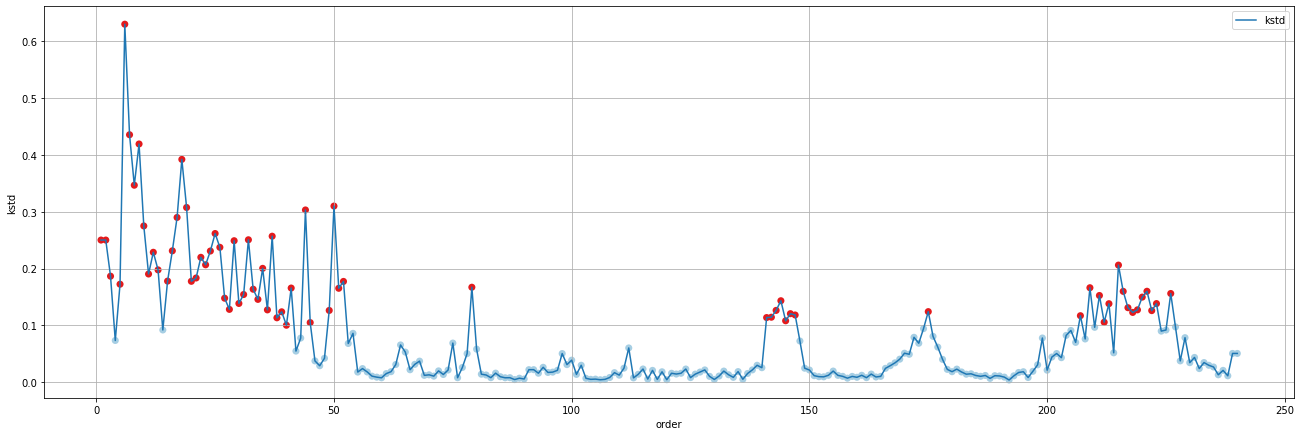

In [10]:
color_palette = sns.color_palette('Paired', 6)
cluster_colors = [color_palette[x] for x in clabels]

ax = df_clust.plot.scatter(x='order', y='kstd', s=50, linewidth=0, c=cluster_colors, figsize=(6.4*3.5, 4.8*1.5));
df_clust.plot(x='order', y='kstd', figsize=(6.4*3.5, 4.8*1.5), ax=ax)
plt.grid()